In [1]:
%pylab inline

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d

#from mpl_toolkits import mplot3d

from matplotlib import cm
import seaborn as sns
import os
import json

# 
from keras.layers import Dense, Activation
from keras.models import Sequential
#
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import math

from sklearn import datasets, linear_model
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# for Jupyter notebook
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
DATA_PATH = 'data'

### Считываем данные экспериментов + базовый EDA

In [3]:
datafile = os.path.join(DATA_PATH, 'kappa.csv')
df = pd.read_csv(datafile)

In [4]:
df.head()

,R,x,y,T,L,kappa,kappa_bulk
0,0.1,10,20,100,1.000000e-09,0.333148,0.014405
1,0.1,10,20,100,1.258930e-09,0.409962,0.017727
2,0.1,10,20,100,1.584890e-09,0.502859,0.021743
3,0.1,10,20,100,1.995260e-09,0.614522,0.026572
4,0.1,10,20,100,2.511890e-09,0.747809,0.032335


In [5]:
df.shape

(102816, 7)

In [6]:
columns = list(df.columns)
columns

['R', 'x', 'y', 'T', 'L', 'kappa', 'kappa_bulk']

In [84]:
# выделяем колонки зависимых элементов и независимых
y_column = 'kappa_bulk'
y = df[y_column]
y = y.values.reshape(-1,1)  # преобразовать вектор в одномерный массив

if y_column in columns:
    columns.remove(y_column)

X = df[columns]

print(f"X.shape={X.shape}, y.shape={y.shape}")

X.shape=(102816, 6), y.shape=(102816, 1)


In [85]:
X.head()

,R,x,y,T,L,kappa
0,0.1,10,20,100,1.000000e-09,0.333148
1,0.1,10,20,100,1.258930e-09,0.409962
2,0.1,10,20,100,1.584890e-09,0.502859
3,0.1,10,20,100,1.995260e-09,0.614522
4,0.1,10,20,100,2.511890e-09,0.747809


In [86]:
# получаем диапозон значений (для масштабировния, либо для отсечений выбросов и тд.)
X_min = np.min(X).rename("min")
X_max = np.max(X).rename("max")

y_min = np.min(y)
y_max = np.max(y)

In [87]:
pd.concat([X_min, X_max], axis=1)  # смотрим диапозон
# 1. При использовании лин методов - нужно масштабирование (т.к. очень большой разброс значений - L от 10^-9, а T до 500)

,min,max
R,0.000000e+00,0.9000
x,1.000000e+00,20.0000
y,1.000000e+00,20.0000
T,1.000000e+02,500.0000
L,1.000000e-09,0.0001
kappa,2.717430e-01,44.7913


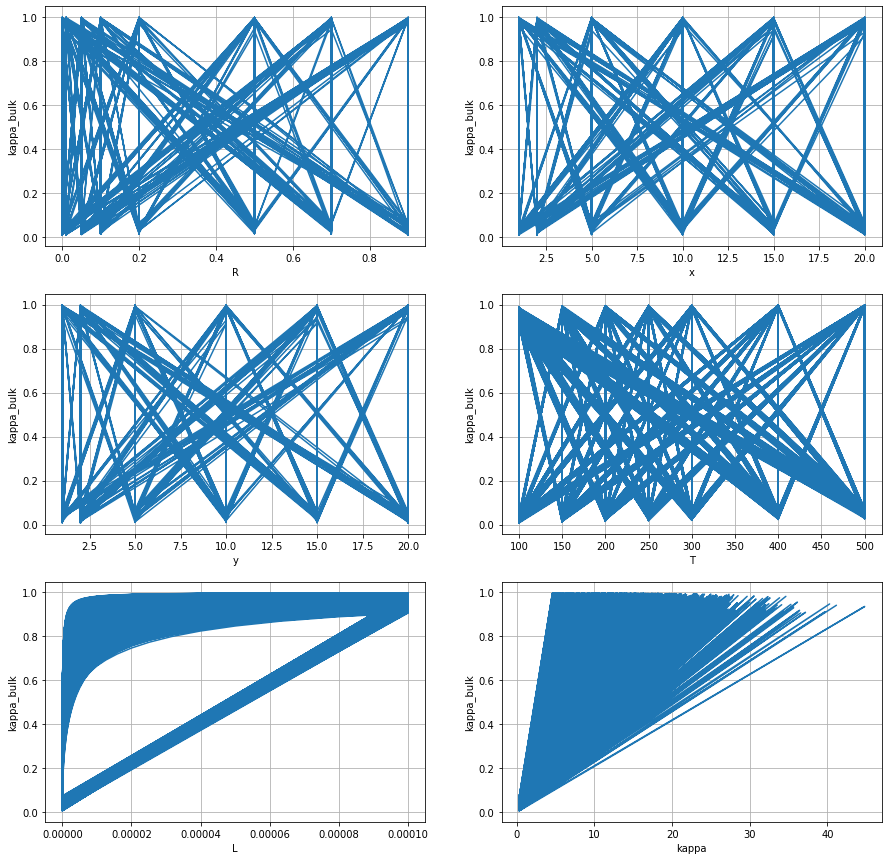

In [88]:
# смотрим графики результата от каждого столбца
def plot_functions(X, y):
    """
    X shape must be (,6)
    y shape must be columns vector
    X.shape[0] == y.shape
    """
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize = (15,15))

    for i in range( len(columns)):
        x_label = columns[i]
        row = int(i/2)
        col = int(i%2)
        axs[row, col].plot(X[x_label],y)
        axs[row, col].set_xlabel(x_label)
        axs[row, col].set_ylabel(y_column)
        axs[row, col].grid(True)

plot_functions(X, y)

In [89]:
# Выводы
# 1. 5 - логарифмический характер и линейный кое-где
# 2. 1-4 - кусочно-линейный зависимости (можно использовать модели на кусочно-линейной основе)

In [90]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

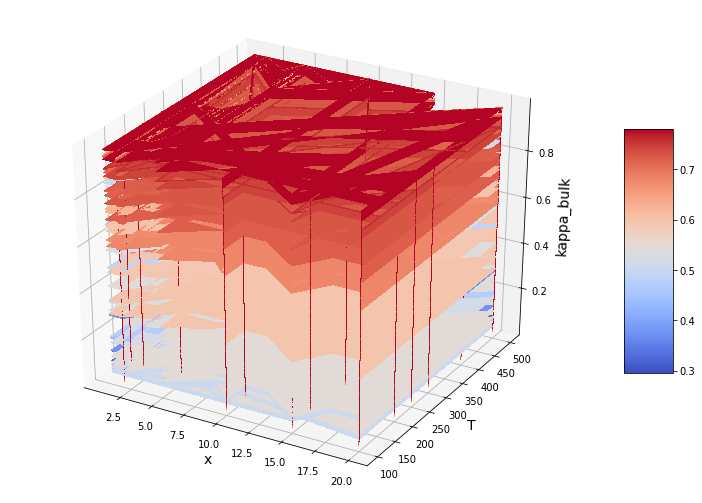

In [93]:
# т.к. у нас функция многих переменных (5) то можем построить хотя бы в 3мерном пространстве
def plot_3d(X, Y, z, X_label, Y_label, z_label, maxlen=1000):  
    # maxlen - количество данных для графика
    fancy = False

    if X.shape[0] > maxlen:
        # слычайный массив по диапозону от/до + сортируем (для получения возрастающих индексов)
        indicies = np.sort( np.random.randint(0, X.shape[0], size=maxlen))  
        fancy = True
    
    fig = plt.figure(figsize=(13,9))
    ax = fig.gca(projection='3d')

    if fancy:
        surf = ax.plot_surface(X[indicies], 
                               Y[indicies], 
                               z[indicies], 
                               cmap=cm.coolwarm,
                               linewidth=0, 
                               antialiased=False)
    else:
        surf = ax.plot_surface(X, Y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_xlabel(X_label, fontsize=14)
    ax.set_ylabel(Y_label, fontsize=14)
    ax.set_zlabel(z_label, fontsize=14)

idx1 = 1
idx2 = 3
plot_3d(X[columns[idx1]], X[columns[idx2]], y, columns[idx1], columns[idx2],  y_column)

In [94]:
# Выводы
# 1. есть плоскости (уровни) - линейная зависимоть
# 2. X [2.5 - 7.5] и T [100 - 200] - разорванный - плохо себя показывает, нет стабильности, нужно исследовать

### Create "normalized" (scaled) versions of input vectors

In [95]:
# нормализованные версии входных векторов
X_scaler = StandardScaler() #MinMaxScaler()
X_scaled = X_scaler.fit_transform(X)
y_scaler = StandardScaler() #MinMaxScaler()
y_scaled = y_scaler.fit_transform(y).ravel()

### Linear Regression

<img src="images/multivariate-linear-regression.webp" width=500 height=500>
<a href="https://xplordat.com/2018/05/31/multivariate-regression-with-neural-networks-unique-exact-and-generic-models/">https://xplordat.com/2018/05/31/multivariate-regression-with-neural-networks-unique-exact-and-generic-models/</a>

In [98]:
# линейная регрессия (для анализа похожести нашей функции на линейную)
# 1. создаем модель linear_model.LinearRegression()
# 2. обучаем .fit(X_scaled, y_scaled) 
linreg = linear_model.LinearRegression().fit(X_scaled, y_scaled)  

In [99]:
# score - как хорошо сработала модель
# 0.7 - достаточно хороший -> кусочно-линейность присутствует
linreg.score(X_scaled, y_scaled) # Return the coefficient of determination R^2 of the prediction.

0.7085335957349419

In [100]:
# параметры
linreg.coef_

array([ 0.21430593,  0.04192516, -0.11490646,  0.27759032,  0.20782839,
        0.75243297])

In [101]:
# используем для предсказания
y_pred = linreg.predict(X_scaled)

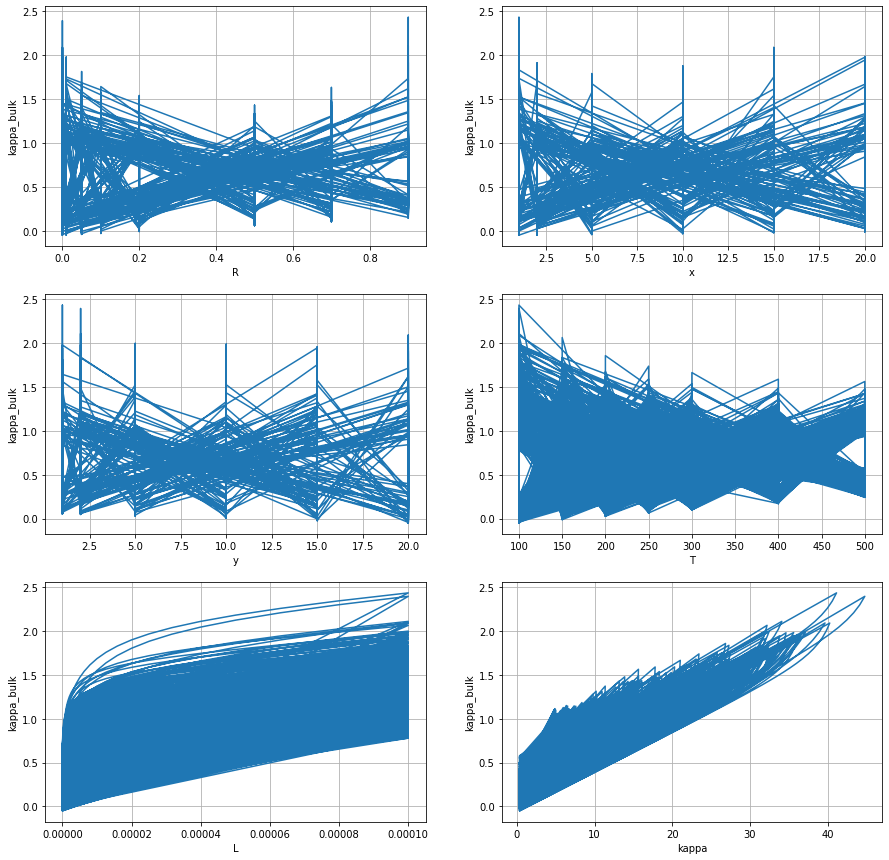

In [19]:
# график предсказаний ?
plot_functions( X, y_scaler.inverse_transform(y_pred))

In [102]:
# ф-ция для сравнения результатов двух моделей (строит два графика для сравеннеия)
def plot_comparision(X1, X2, y1, y2, x_label, y_label, scale=False):
    """
    X1.shape == y1.shape
    X2.shape == y2.shape
    """
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (15,5))

    
    if scale:
        y_min = min( min(y1), min(y2))
        y_max = max( max(y1), max(y2))

    col = 0
    axs[col].plot(X1,y1)
    axs[col].set_xlabel(x_label)
    axs[col].set_ylabel(y_label)
    axs[col].grid(True)
    if scale:
        axs[col].set_ylim(y_min, y_max)

    col = 1   
    axs[col].plot(X2,y2)
    axs[col].set_xlabel(x_label)
    axs[col].set_ylabel(y_label)
    axs[col].grid(True)
    if scale:
        axs[col].set_ylim(y_min, y_max)

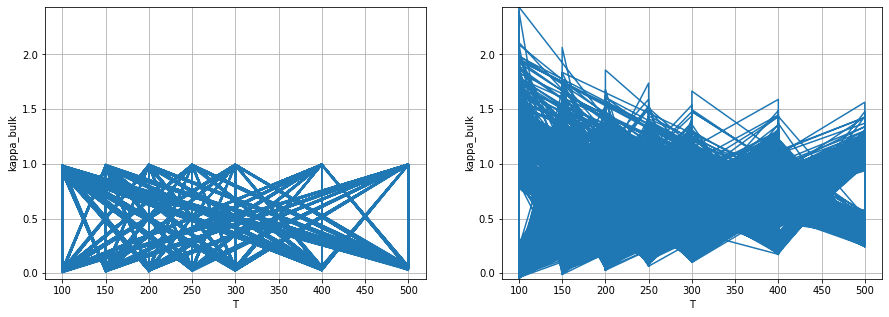

In [103]:
# сравниваем как наша модеь отрабатывает по отношению к реальным данным
# смотрим два варианта (зависимость целевой от измерения (стобца X) под номером idx = 3)
idx = 3
plot_comparision(X[columns[idx]], 
                 X[columns[idx]], 
                 y, 
                 y_scaler.inverse_transform(y_pred), 
                 columns[idx], 
                 y_column,
                 scale=True)

In [22]:
# Сделайте то же самое, но с Lasso regression / Ridge regressin (возожно нужно будет уменьшить количество данных. см ниже пример)

# Ваш код



In [23]:
# Сравните качество аппроксимации всех трех видов регрессии (выбираем метрику, Обосновать почему ее)

# Ваш код



### Обоснуйте:
* выбор метода сравнения
* какой метод из 3х лучший и, на Ваш взгляд, чем это объясняется


(текст)


## Kernels ...


<img src="images/main-qimg-25567815755196bd6837ee1f7eafe435.png" width=900>
<a href="https://www.quora.com/How-do-I-intuitively-understand-Kernel-in-kernel-ridge-regression-Gaussian-kernel-regression-and-SVM-kernels-Are-they-all-the-same">https://www.quora.com/How-do-I-intuitively-understand-Kernel-in-kernel-ridge-regression-Gaussian-kernel-regression-and-SVM-kernels-Are-they-all-the-same</a>

<img src="images/Illustration-of-kernel-regression-using-a-Gaussian-kernel-of-bandwidth-01-blue-03.png" width=800>
<a href="https://www.researchgate.net/figure/Illustration-of-kernel-regression-using-a-Gaussian-kernel-of-bandwidth-01-blue-03_fig3_228884404">https://www.researchgate.net/figure/Illustration-of-kernel-regression-using-a-Gaussian-kernel-of-bandwidth-01-blue-03_fig3_228884404</a>

### Support Vector Regression (SVR) using linear and non-linear kernels

In [104]:
from sklearn.svm import SVR # метод опорных векторов

In [105]:
# Fit regression model
# C - lambda (Regularization parameter)

# рязные ядра для аппроксимации
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1)

In [106]:
maxlen = 1000
indicies = np.sort( np.random.randint(0, X.shape[0], size=maxlen))  # массив случайных чисел отсортированный

In [107]:
%%time
svr_lin.fit(X.values[indicies], y[indicies].ravel())
# долго выполняется даже для maxlen = 1000 (учитывая дяже что используем линейное ядро)

Wall time: 36.4 s


SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [108]:
y_svr_lin = svr_lin.predict(X)

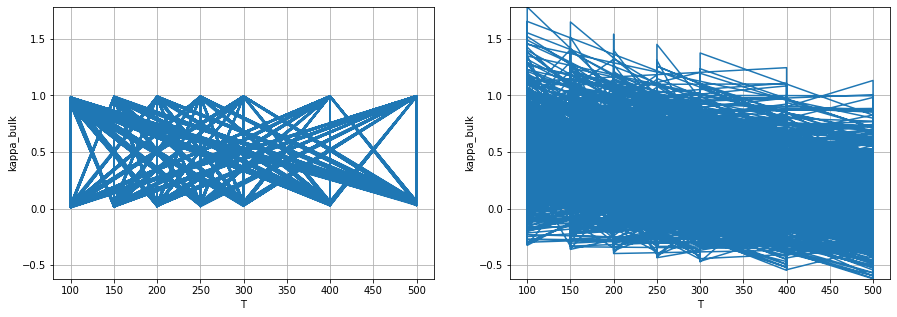

In [109]:
idx = 3
plot_comparision(X[columns[idx]], 
                 X[columns[idx]], 
                 y, 
                 y_svr_lin, 
                 columns[idx], 
                 y_column,
                 scale=True)

In [ ]:
# Выводы
# с линейным ядром полуилась каша -> метод с таким ядром плохо применим.
# Попробуем другие ядра

In [110]:
%%time
maxlen = 10000
indicies = np.sort( np.random.randint(0, X.shape[0], size=maxlen))
svr_rbf.fit(X.values[indicies], y[indicies].ravel())

Wall time: 5.7 s


SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [111]:
y_svr_rbf = svr_rbf.predict(X)

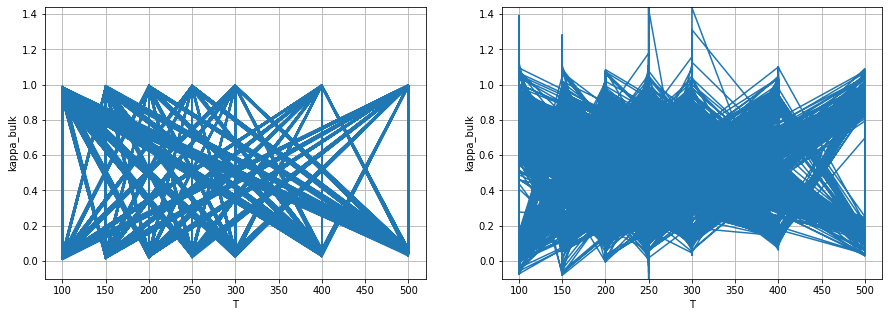

In [112]:
idx = 3
plot_comparision(X[columns[idx]], 
                 X[columns[idx]], 
                 y, 
                 y_svr_rbf, 
                 columns[idx], 
                 y_column,
                 scale=True)

In [113]:
# Выводы
# Более внятная картина (даже с 10% данные используемыми)

### Kernel Ridge regression


In [ ]:
# Тут пробуем гребневую регрессию просто как вариант попробовать

In [114]:
from sklearn.kernel_ridge import KernelRidge

In [115]:
maxlen = 20000
indicies = np.sort( np.random.randint(0, X.shape[0], size=maxlen))

In [116]:
%%time
krreg = KernelRidge(alpha=1.0)
krreg.fit(X_scaled[indicies], y_scaled[indicies])

Wall time: 31.8 s


KernelRidge(alpha=1.0, coef0=1, degree=3, gamma=None, kernel='linear',
            kernel_params=None)

In [117]:
%%time
y_kridge = krreg.predict(X_scaled)

Wall time: 8min 52s


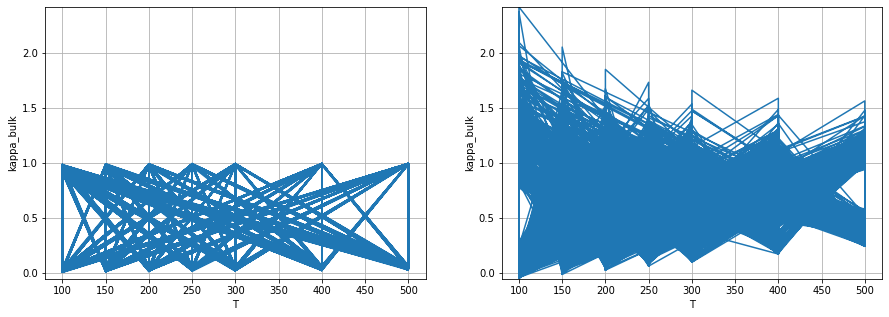

In [118]:
idx = 3
plot_comparision(X[columns[idx]],
                 X[columns[idx]], 
                 y,
                 y_scaler.inverse_transform(y_kridge),
                 columns[idx],
                 y_column,
                 scale=True)

## MLP (Multilayer Perceptron) based function approximation

<img src="images/a-The-building-block-of-deep-neural-networks-artificial-neuron-or-node-Each-input-x.png" width=600 height=600>

<a href="https://www.researchgate.net/figure/a-The-building-block-of-deep-neural-networks-artificial-neuron-or-node-Each-input-x_fig1_312205163">https://www.researchgate.net/figure/a-The-building-block-of-deep-neural-networks-artificial-neuron-or-node-Each-input-x_fig1_312205163</a>

### MLPRegressor (scikit-learn)

In [38]:
%%time

# количество входных переменных
inp_size = X.shape[1]
out_size = y.shape[1]

base = (inp_size + out_size) * math.log2(X.shape[0]) # количество нейронов в каждом слое
# 3 слоя
L1_size = int( base * 3 ) 
L2_size = int( base * 2 )
L3_size = int( base * 1 )
print(f"neurons: L1=<{L1_size}>, L2=<{L2_size}>, L3=<{L3_size}>")

mlp = MLPRegressor(solver='adam',
                   alpha=1e-4,
                   activation='relu',
                   learning_rate_init = 0.01,
                   max_iter=1000,
                   hidden_layer_sizes=(L1_size, L2_size, L3_size, out_size),
                   shuffle=True,
                   random_state=12)

#skf = StratifiedKFold( n_splits=5, shuffle=True, random_state=25)

#scores_mse = cross_val_score(mlp, X_scaled, y_scaled, scoring='neg_mean_squared_error', cv=3)

print(X_scaled.shape,y_scaled.shape,y_scaled.reshape(-1, 1).shape)

mlp =  mlp.fit(X_scaled, y_scaled)

neurons: L1=<349>, L2=<233>, L3=<116>
(102816, 6) (102816,) (102816, 1)
CPU times: user 57min 8s, sys: 1h 4min 45s, total: 2h 1min 54s
Wall time: 2min 32s


In [39]:
#test_size = 1000
#test_X = np.zeros([test_size, len(columns)])

#for i in range(len(columns)):
#    test_X[:,i] = np.sort(np.random.uniform(low=X_min[columns[i]],
#                                            high=X_max[columns[i]],
#                                            size=(test_size,)))   

test_y = y_scaler.inverse_transform( mlp.predict(X_scaler.transform(X)))


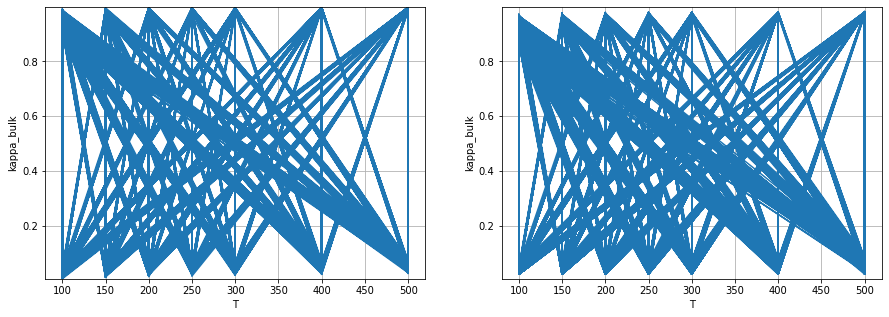

In [40]:
idx = 3
plot_comparision(X[columns[idx]],
                 X[columns[idx]], 
                 y,
                 test_y,
                 columns[idx],
                 y_column,
                 scale=True)

In [ ]:
# Вывод:
# 1) очень похожа на входную функцию
# 2) Можно убрать все слои кроме первого -> получится точно такой же график (почти не изменился)
# 3) Если сделать только два слоя (1 и 2), не меняя ничего больше -> выдаст прямую горизонтальную!!! -> сеть вырождается
# то есть обнуляются градиенты где-то. 

### Keras model

In [41]:
# подход точно такой же как в выше
# но сами строим сеть последовательно

# Keras model

from keras.initializers import RandomNormal
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

base = (inp_size + out_size) * math.log(X.shape[0], 2)
L1_size = int( base * 3 )
L2_size = int( base * 2 )
L3_size = int( base * 1 )

# Initialisation of the NN
model = Sequential()  # последовательная модель

# Input layer and the first hidden layer
# Dense - обычный слой многослойного персептрона
model.add(Dense(L1_size, activation = 'relu', input_dim = X.shape[1])) #, kernel_initializer=RandomNormal(stddev=0.001)))

# Second hidden layer
model.add(Dense(units = L2_size, activation = 'relu')) #, kernel_initializer=RandomNormal(stddev=0.001)))

# Third hidden layer
model.add(Dense(units = L3_size, activation = 'relu')) #, kernel_initializer=RandomNormal(stddev=0.001)))

# Output layer
model.add(Dense(units = 1))

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 349)               2443      
_________________________________________________________________
dense_1 (Dense)              (None, 233)               81550     
_________________________________________________________________
dense_2 (Dense)              (None, 116)               27144     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 117       
Total params: 111,254
Trainable params: 111,254
Non-trainable params: 0
_________________________________________________________________


In [43]:
%%time

adam = Adam(lr=0.001)
model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mse'])
history = model.fit(X, y, epochs=10)

Epoch 1/10
3213/3213 [==============================] - 9s 3ms/step - loss: 1.2742 - mse: 1.2742
Epoch 2/10
3213/3213 [==============================] - 9s 3ms/step - loss: 0.0341 - mse: 0.0341
Epoch 3/10
3213/3213 [==============================] - 9s 3ms/step - loss: 0.0130 - mse: 0.0130
Epoch 4/10
3213/3213 [==============================] - 9s 3ms/step - loss: 0.0100 - mse: 0.0100
Epoch 5/10
3213/3213 [==============================] - 9s 3ms/step - loss: 0.0075 - mse: 0.0075
Epoch 6/10
3213/3213 [==============================] - 9s 3ms/step - loss: 0.0063 - mse: 0.0063
Epoch 7/10
3213/3213 [==============================] - 9s 3ms/step - loss: 0.0052 - mse: 0.0052
Epoch 8/10
3213/3213 [==============================] - 9s 3ms/step - loss: 0.0042 - mse: 0.0042
Epoch 9/10
3213/3213 [==============================] - 9s 3ms/step - loss: 0.0038 - mse: 0.0038
Epoch 10/10
3213/3213 [==============================] - 9s 3ms/step - loss: 0.0035 - mse: 0.0035
CPU times: user 9min 12s, sys

In [44]:
y_keras = model.predict(X)

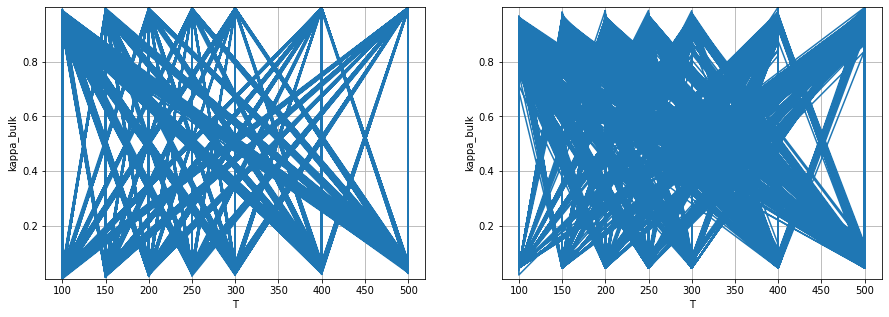

In [45]:
idx = 3
plot_comparision(X[columns[idx]],
                 X[columns[idx]], 
                 y,
                 y_keras,
                 columns[idx],
                 y_column,
                 scale=True)

In [ ]:
# Плюсы keras по сравнению с предыдущей сеткой:
# 0. Можно настроить модель (нач инициализацию, активация) + очень точно настраивать параметры каждого слоя
# 1. Можем очень точно настроить сеть в keras (например использовать гип.тангенс как активацию)
# 2. в keras задаем количество эпох где смотрим стстатистику сети -> можем увидеть среднеквадр. ошибку

In [46]:
# Запустите эту (возможно, с другим числом слоев и нейронов) сетку с оптимизатором RMSprop

# Ваш код



In [47]:
# Подберите параметры сети так, чтобы результат стал более приемлемым ...

# Ваш код



### Почему результаты отличаются, хотя сети +/- одинаковые

### Поясните

(Ваш текст)

In [ ]:
# все внешне единтично